In [58]:
from utils import *
from sklearn.datasets import make_friedman2
from multiprocessing import Pool
from scipy import optimize

# Friedman 2 Data

## Dataset

In [59]:
# add noise
# redo with scipy.minimize
X, y = make_friedman2(random_state=18397425)
datasets = processing(X, y)

X, y = datasets['orig']
X_norm, y_norm = datasets['norm']
X_train, y_train, y_train_noisy = datasets['orig train']
X_train_norm, y_train_norm, y_train_norm_noisy = datasets['norm train']

## Noiseless

### $\mathbb{R}^d$

In [60]:
ntk_1 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=3, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e0)
    ) 
)

ntk_2 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=100, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e0)
    ) 
)

lpk = (
    ConstantKernel(
        constant_value=0.224**2, 
        constant_value_bounds='fixed'#(1e-9, 1e5) 
    ) * 
    Matern(
        nu=1/2,
        length_scale=1,
        length_scale_bounds='fixed'#(1e-1, 1e3), 
    ) 
)

gp_ntk_1 = GPR(kernel=ntk_1, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_1.fit(X_train, y_train)
print('NTK     : ', gp_ntk_1.kernel_)
mean_ntk_1 = gp_ntk_1.predict(X)

gp_ntk_2 = GPR(kernel=ntk_2, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_2.fit(X_train, y_train)
print('NTK     : ', gp_ntk_2.kernel_)
mean_ntk_2 = gp_ntk_2.predict(X)

gp_lpk = GPR(kernel=lpk, alpha=1e-9, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)
gp_lpk.fit(X_train, y_train)
print('Laplace : ', gp_lpk.kernel_)
mean_lpk = gp_lpk.predict(X)

NTK     :  0.0113**2 * NTK(depth=3, c=2.000, bias=0.056)
NTK     :  0.000429**2 * NTK(depth=100, c=2.000, bias=0.002)
Laplace :  0.224**2 * Matern(length_scale=1, nu=0.5)


In [61]:
# def f(args):
#     ell, gp, X, X_train, y_train, residual_target, out = args
#     gp.set_params(**{'kernel__k2__length_scale': ell})
#     gp.fit(X_train, y_train)

#     if out:
#         print(gp)
        
#     mean = gp.predict(X)
#     return np.corrcoef((residual_target)[:,0], (y-mean)[:,0])[0, 1]

In [62]:
# arg_list = (gp_lpk, X, X_train, y_train, y-mean_ntk_1, False)
# N = 10000
# ell_search = np.linspace(0.001, 30, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_1 = p.map(f, args)
#     i = np.argmax(result_1)
#     print(f"NTK depth 3, LPK lengthscale {ell_search[i]} at {i} with {max(result_1)}")

In [63]:
# arg_list = (gp_lpk, X, X_train, y_train, y-mean_ntk_2, False)
# N = 10000
# ell_search = np.linspace(0.001, 30, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_2 = p.map(f, args)
#     i = np.argmax(result_2)
#     print(f"NTK depth 100, LPK lengthscale {ell_search[i]} at {i} with {max(result_2)}")

In [64]:
def g(ell, residual):
    gp_lpk.set_params(**{'kernel__k2__length_scale': ell})
    gp_lpk.fit(X_train, y_train)
    mean = gp_lpk.predict(X)
    return -np.corrcoef((residual)[:,0], (y-mean)[:,0])[0, 1]

In [65]:
ell_3 = optimize.minimize_scalar(g, args=(y-mean_ntk_1), method='bounded', bounds=[0.001, 100], options={'disp':3})
ell_3

 
 Func-count     x          f(x)          Procedure
    1        38.1972    -0.656757        initial
    2        61.8038    -0.645999        golden
    3        23.6076     -0.65597        golden
    4        32.9248     -0.65831        parabolic
    5        31.6242    -0.658479        parabolic
    6        29.6672    -0.658501        parabolic
    7        27.3526    -0.658071        golden
    8        30.4923    -0.658529        parabolic
    9        30.5071    -0.658529        parabolic
   10        30.4881    -0.658529        parabolic
   11        30.4877    -0.658529        parabolic
   12        30.4877    -0.658529        parabolic
   13        30.4877    -0.658529        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )


     fun: -0.65852938042022
 message: 'Solution found.'
    nfev: 13
     nit: 13
  status: 0
 success: True
       x: 30.48768459024271

In [66]:
ell_100 = optimize.minimize_scalar(g, args=(y-mean_ntk_2), method='bounded', bounds=[0.001, 100], options={'disp':3})
ell_100

 
 Func-count     x          f(x)          Procedure
    1        38.1972    -0.644372        initial
    2        61.8038    -0.631492        golden
    3        23.6076    -0.646424        golden
    4        24.2658    -0.646779        parabolic
    5        29.4592    -0.647599        parabolic
    6        32.7968    -0.646806        golden
    7        28.5658    -0.647667        parabolic
    8        28.0184    -0.647671        parabolic
    9        28.1994    -0.647673        parabolic
   10         28.204    -0.647673        parabolic
   11        28.2027    -0.647673        parabolic
   12        28.2027    -0.647673        parabolic
   13        28.2027    -0.647673        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )


     fun: -0.6476731549688525
 message: 'Solution found.'
    nfev: 13
     nit: 13
  status: 0
 success: True
       x: 28.202666546225164

In [67]:
# D=3
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_3.x})
gp_lpk.fit(X_train, y_train)
mean_opt_1 = gp_lpk.predict(X)

# D=100
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_100.x})
gp_lpk.fit(X_train, y_train)
mean_opt_2 = gp_lpk.predict(X)

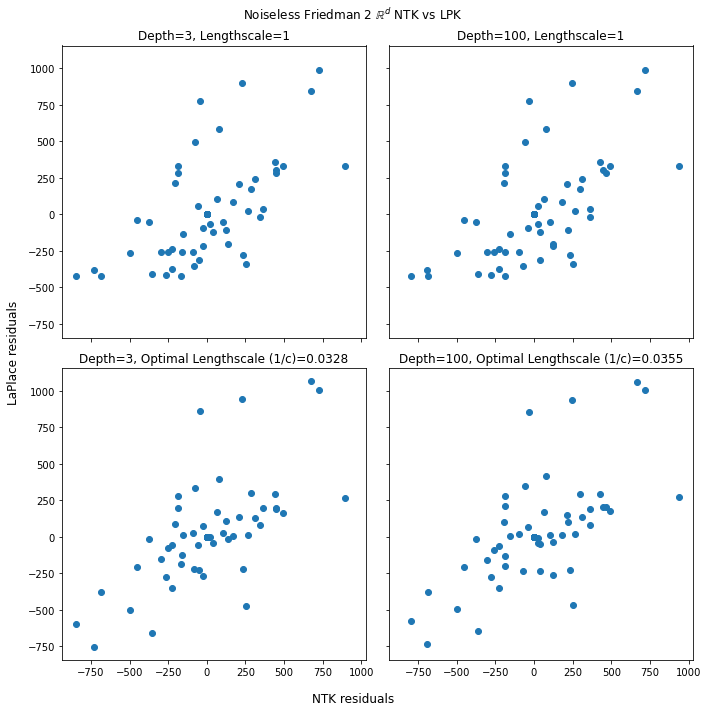

In [68]:
fig1, ax1 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
ax1 = ax1.ravel()
ax1[0].scatter(y - mean_ntk_1, y - mean_lpk)
ax1[0].set_title('Depth=3, Lengthscale=1')
ax1[1].scatter(y - mean_ntk_2, y - mean_lpk)
ax1[1].set_title('Depth=100, Lengthscale=1')
ax1[2].scatter(y - mean_ntk_1, y - mean_opt_1)
ax1[2].set_title(f'Depth=3, Optimal Lengthscale (1/c)={round(ell_3.x, 4)}')
ax1[3].scatter(y - mean_ntk_2, y - mean_opt_2)
ax1[3].set_title(f'Depth=100, Optimal Lengthscale (1/c)={round(ell_100.x, 4)}')
fig1.suptitle(r'Noiseless Friedman 2 $\mathbb{R}^d$ NTK vs LPK')
fig1.supxlabel('NTK residuals')
fig1.supylabel('LaPlace residuals')
fig1.tight_layout()

### $\mathbb{S}^{d-1}$

In [69]:
ntk_1 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=3, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e0)
    ) 
)

ntk_2 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=100, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e0)
    ) 
)

lpk = (
    ConstantKernel(
        constant_value=0.224**2, 
        constant_value_bounds='fixed'#(1e-9, 1e5) 
    ) * 
    Matern(
        nu=1/2,
        length_scale=1,
        length_scale_bounds='fixed'#(1e-1, 1e3), 
    ) 
)

gp_ntk_1 = GPR(kernel=ntk_1, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_1.fit(X_train_norm, y_train)
print('NTK     : ', gp_ntk_1.kernel_)
mean_ntk_1 = gp_ntk_1.predict(X_norm)

gp_ntk_2 = GPR(kernel=ntk_2, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_2.fit(X_train_norm, y_train)
print('NTK     : ', gp_ntk_2.kernel_)
mean_ntk_2 = gp_ntk_2.predict(X_norm)

gp_lpk = GPR(kernel=lpk, alpha=1e-9, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)
gp_lpk.fit(X_train_norm, y_train)
print('Laplace : ', gp_lpk.kernel_)
mean_lpk = gp_lpk.predict(X_norm)

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


NTK     :  6.87**2 * NTK(depth=3, c=2.000, bias=0.882)
NTK     :  0.306**2 * NTK(depth=100, c=2.000, bias=0.313)
Laplace :  0.224**2 * Matern(length_scale=1, nu=0.5)


In [70]:
# arg_list = (gp_lpk, X_norm, X_train_norm, y_train, y-mean_ntk_1, False)
# N = 10000
# ell_search = np.linspace(0.01, 100, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_1 = p.map(f, args)
#     i = np.argmax(result_1)
#     print(f"NTK depth 3, LPK lengthscale {ell_search[i]} at {i} with {max(result_1)}")

In [71]:
# arg_list = (gp_lpk, X_norm, X_train_norm, y_train, y-mean_ntk_2, False)
# N = 10000
# ell_search = np.linspace(0.01, 100, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_1 = p.map(f, args)
#     i = np.argmax(result_1)
#     print(f"NTK depth 3, LPK lengthscale {ell_search[i]} at {i} with {max(result_1)}")

In [72]:
def g(ell, residual):
    gp_lpk.set_params(**{'kernel__k2__length_scale': ell})
    gp_lpk.fit(X_train_norm, y_train)
    mean = gp_lpk.predict(X_norm)
    return -np.corrcoef((residual)[:,0], (y-mean)[:,0])[0, 1]

In [73]:
ell_3 = optimize.minimize_scalar(g, args=(y-mean_ntk_1), method='bounded', bounds=[0.001, 30], options={'disp':3})
ell_3

 
 Func-count     x          f(x)          Procedure
    1        11.4596    -0.999999        initial
    2        18.5414    -0.999999        golden
    3        22.9182    -0.999999        golden
    4        21.1542    -0.999999        parabolic
    5        21.5428    -0.999999        parabolic
    6        21.4614    -0.999999        parabolic
    7        21.4541    -0.999999        parabolic
    8        21.4542    -0.999999        parabolic
    9        21.3395    -0.999999        golden
   10        21.4103    -0.999999        golden
   11        21.4374    -0.999999        golden
   12        21.4477    -0.999999        golden
   13        21.4512    -0.999999        parabolic
   14        21.4526    -0.999999        parabolic
   15        21.4499    -0.999999        golden
   16        21.4517    -0.999999        golden
   17        21.4507    -0.999999        golden
   18        21.4514    -0.999999        golden
   19        21.4513    -0.999999        parabolic
   20     

     fun: -0.9999988106985284
 message: 'Solution found.'
    nfev: 21
     nit: 21
  status: 0
 success: True
       x: 21.451285392788023

In [74]:
ell_100 = optimize.minimize_scalar(g, args=(y-mean_ntk_2), method='bounded', bounds=[0.001, 30], options={'disp':3})
ell_100

 
 Func-count     x          f(x)          Procedure
    1        11.4596     -0.99947        initial
    2        18.5414    -0.999469        golden
    3         7.0828     -0.99947        golden
    4         4.3778    -0.999472        golden
    5        2.70601    -0.999474        golden
    6        1.67279    -0.999477        golden
    7        1.03422    -0.999483        golden
    8       0.639566    -0.999495        golden
    9       0.395655     -0.99952        golden
   10        0.24491    -0.999572        golden
   11       0.151745    -0.999675        golden
   12      0.0941655    -0.999809        golden
   13      0.0585794    -0.999741        golden
   14      0.0974708    -0.999801        parabolic
   15      0.0851503    -0.999826        parabolic
   16      0.0750011     -0.99983        golden
   17      0.0776763    -0.999831        parabolic
   18      0.0785217    -0.999831        parabolic
   19       0.078182    -0.999831        parabolic
   20      0.078189

     fun: -0.9998312901127916
 message: 'Solution found.'
    nfev: 22
     nit: 22
  status: 0
 success: True
       x: 0.07818627825716633

In [75]:
# D=3
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_3.x})
gp_lpk.fit(X_train_norm, y_train)
mean_opt_1 = gp_lpk.predict(X_norm)

# D=100
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_100.x})
gp_lpk.fit(X_train_norm, y_train)
mean_opt_2 = gp_lpk.predict(X_norm)

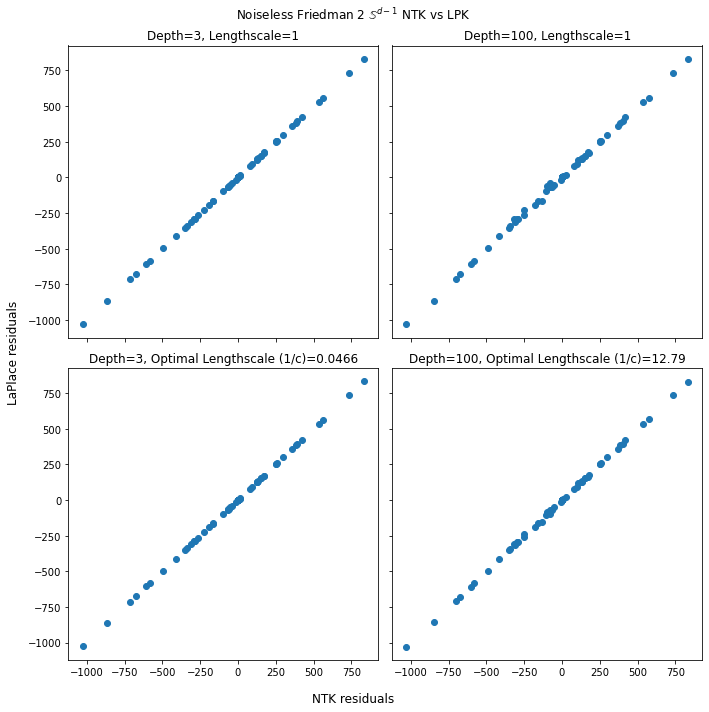

In [76]:
fig2, ax2 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
ax2 = ax2.ravel()
ax2[0].scatter(y - mean_ntk_1, y - mean_lpk)
ax2[0].set_title('Depth=3, Lengthscale=1')
ax2[1].scatter(y - mean_ntk_2, y - mean_lpk)
ax2[1].set_title('Depth=100, Lengthscale=1')
ax2[2].scatter(y - mean_ntk_1, y - mean_opt_1)
ax2[2].set_title(f'Depth=3, Optimal Lengthscale (1/c)={round(ell_3.x, 4)}')
ax2[3].scatter(y - mean_ntk_2, y - mean_opt_2)
ax2[3].set_title(f'Depth=100, Optimal Lengthscale (1/c)={round(ell_100.x, 4)}')
fig2.suptitle(r'Noiseless Friedman 2 $\mathbb{S}^{d-1}$ NTK vs LPK')
fig2.supxlabel('NTK residuals')
fig2.supylabel('LaPlace residuals')
fig2.tight_layout()

### RBF

In [77]:
rbf = (
        ConstantKernel(
            constant_value=0.224**2, 
            constant_value_bounds='fixed'#(1e-9, 1e5) 
        ) * 
        Matern(
            nu=np.inf,
            length_scale=1,
            length_scale_bounds='fixed',#(1e-1, 1e3), 
        ) 
    )

gp_rbf = GPR(kernel=rbf, alpha=1e-9, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)
gp_rbf.fit(X_train_norm, y_train)
mean_rbf = gp_rbf.predict(X_norm)

In [78]:
def h(ell, residual):
    gp_rbf.set_params(**{'kernel__k2__length_scale': ell})
    gp_rbf.fit(X_train_norm, y_train)
    mean = gp_rbf.predict(X_norm)
    return -np.corrcoef((residual)[:,0], (y-mean)[:,0])[0, 1]

In [79]:
ell_3 = optimize.minimize_scalar(h, args=(y-mean_ntk_1), method='bounded', bounds=[0.001, 10000], options={'disp':3})
ell_3

 
 Func-count     x          f(x)          Procedure
    1        3819.66    -0.526136        initial
    2        6180.34    -0.506453        golden
    3        2360.68    -0.539007        golden
    4        1458.98    -0.547495        golden
    5          901.7    -0.556193        golden
    6        557.282    -0.566571        golden
    7         344.42    -0.576029        golden
    8        212.863    -0.582045        golden
    9        131.557    -0.584948        golden
   10        81.3072    -0.585988        golden
   11        15.7463    -0.582536        parabolic
   12        90.0941    -0.585882        parabolic
   13        56.6426    -0.585893        parabolic
   14        71.8861    -0.586039        golden
   15        72.1764    -0.586038        parabolic
   16        70.9074    -0.586039        parabolic
   17        70.9787    -0.586039        parabolic
   18        71.0842    -0.586039        parabolic
   19         70.991    -0.586039        parabolic
   20     

     fun: -0.5860391897802191
 message: 'Solution found.'
    nfev: 37
     nit: 37
  status: 0
 success: True
       x: 70.97867629802221

In [80]:
ell_100 = optimize.minimize_scalar(h, args=(y-mean_ntk_2), method='bounded', bounds=[0.001, 100000], options={'disp':3})
ell_100

 
 Func-count     x          f(x)          Procedure
    1        38196.6     -0.47123        initial
    2        61803.4    -0.469886        golden
    3        23606.8    -0.474575        golden
    4        14589.8    -0.482287        golden
    5           9017    -0.497213        golden
    6        5572.81    -0.517897        golden
    7        3444.19    -0.535984        golden
    8        2128.62    -0.547181        golden
    9        1315.56    -0.555063        golden
   10        813.063    -0.563745        golden
   11        502.501     -0.57373        golden
   12        310.563    -0.582142        golden
   13        191.939    -0.587139        golden
   14        118.625    -0.589406        golden
   15        73.3147    -0.590018        golden
   16        50.0901     -0.58954        parabolic
   17        82.3993    -0.589993        parabolic
   18        75.9613    -0.590018        parabolic
   19        74.9203    -0.590019        parabolic
   20        74.8934  

     fun: -0.5900188841944871
 message: 'Solution found.'
    nfev: 32
     nit: 32
  status: 0
 success: True
       x: 74.90625268140103

In [81]:
# D=3
gp_rbf.set_params(**{'kernel__k2__length_scale': ell_3.x})
gp_rbf.fit(X_train_norm, y_train)
mean_opt_1 = gp_rbf.predict(X_norm)

# D=100
gp_rbf.set_params(**{'kernel__k2__length_scale': ell_100.x})
gp_rbf.fit(X_train_norm, y_train)
mean_opt_2 = gp_rbf.predict(X_norm)

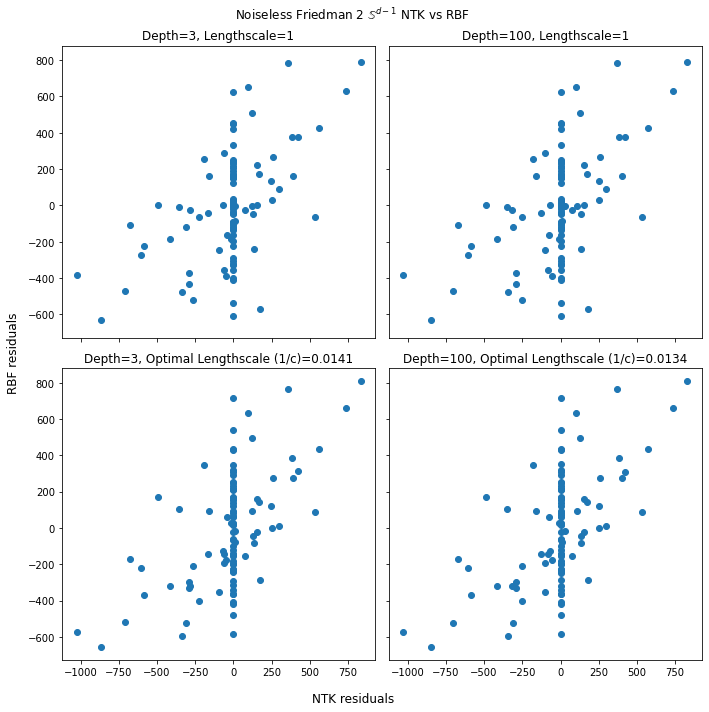

In [82]:
fig2, ax2 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
ax2 = ax2.ravel()
ax2[0].scatter(y - mean_ntk_1, y - mean_rbf)
ax2[0].set_title('Depth=3, Lengthscale=1')
ax2[1].scatter(y - mean_ntk_2, y - mean_rbf)
ax2[1].set_title('Depth=100, Lengthscale=1')
ax2[2].scatter(y - mean_ntk_1, y - mean_opt_1)
ax2[2].set_title(f'Depth=3, Optimal Lengthscale (1/c)={round(ell_3.x, 4)}')
ax2[3].scatter(y - mean_ntk_2, y - mean_opt_2)
ax2[3].set_title(f'Depth=100, Optimal Lengthscale (1/c)={round(ell_100.x, 4)}')
fig2.suptitle(r'Noiseless Friedman 2 $\mathbb{S}^{d-1}$ NTK vs RBF')
fig2.supxlabel('NTK residuals')
fig2.supylabel('RBF residuals')
fig2.tight_layout()

In [83]:
# lengthscale = np.linspace(0.1, 5, 50)

# fig, ax = plt.subplots(nrows=10, ncols=5, sharex=True, sharey=True, figsize=(15, 30))
# ax=ax.ravel()

# for x, ax in zip(lengthscale, ax):
#     rbf = (
#         ConstantKernel(
#             constant_value=0.05, 
#             constant_value_bounds=(1e-9, 1e5) 
#         ) * 
#         Matern(
#             nu=np.inf,
#             length_scale=x,
#             length_scale_bounds='fixed',#(1e-1, 1e3), 
#         ) 
#     )

#     gp = GPR(kernel=rbf, alpha=1e-10, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
#     gp.fit(X_train_norm, y_train)
#     mean_rbf = gp.predict(X_norm)

#     ax.set_title(f'RBF Lengthscale={x.round(2)}')
#     ax.scatter(y-mean_ntk_1, y-mean_rbf)

# fig.suptitle(r"NTK vs RBF Kernel in $\mathbb{S}^{d-1}$")
# fig.supxlabel('NTK residuals')
# fig.supylabel('RBF residuals')
# fig.tight_layout()

In [84]:
# rbf = (
#     ConstantKernel(
#         constant_value=0.05, 
#         constant_value_bounds=(1e-9, 1e5) 
#     ) * 
#     Matern(
#         nu=np.inf,
#         length_scale=0.35,
#         length_scale_bounds=(1e-1, 1e3), 
#     ) 
# )

# gp = GPR(kernel=rbf, alpha=1e-10, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
# gp.fit(X_train_norm, y_train)
# mean_rbf = gp.predict(X_norm)
# print(rbf)
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.set_title(f'RBF Lengthscale={0.35}')
# ax.scatter(y-mean_ntk_1, y-mean_rbf)

In [85]:
np.corrcoef((y-mean_ntk_1)[:,0], (y-mean_rbf)[:,0])

array([[1.       , 0.5377113],
       [0.5377113, 1.       ]])

In [86]:
np.corrcoef((y-mean_ntk_1)[:,0], (y-mean_lpk)[:,0])

array([[1.       , 0.9999957],
       [0.9999957, 1.       ]])

## Dataset

In [87]:
X, y = make_friedman2(noise=0.2, random_state=18397425)
datasets = processing(X, y)

X, y = datasets['orig']
X_norm, y_norm = datasets['norm']
X_train, y_train, y_train_noisy = datasets['orig train']
X_train_norm, y_train_norm, y_train_norm_noisy = datasets['norm train']

## Noisy

### $\mathbb{R}^d$

In [88]:
ntk_1 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=3, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e0)
    ) 
)

ntk_2 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=100, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e0)
    ) 
)

lpk = (
    ConstantKernel(
        constant_value=0.224**2, 
        constant_value_bounds='fixed'#(1e-9, 1e5) 
    ) * 
    Matern(
        nu=1/2,
        length_scale=1,
        length_scale_bounds='fixed'#(1e-1, 1e3), 
    ) 
)

gp_ntk_1 = GPR(kernel=ntk_1, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_1.fit(X_train, y_train)
print('NTK     : ', gp_ntk_1.kernel_)
mean_ntk_1 = gp_ntk_1.predict(X)

gp_ntk_2 = GPR(kernel=ntk_2, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_2.fit(X_train, y_train)
print('NTK     : ', gp_ntk_2.kernel_)
mean_ntk_2 = gp_ntk_2.predict(X)

gp_lpk = GPR(kernel=lpk, alpha=1e-9, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)
gp_lpk.fit(X_train, y_train)
print('Laplace : ', gp_lpk.kernel_)
mean_lpk = gp_lpk.predict(X)

NTK     :  0.0113**2 * NTK(depth=3, c=2.000, bias=0.056)
NTK     :  0.000429**2 * NTK(depth=100, c=2.000, bias=0.002)
Laplace :  0.224**2 * Matern(length_scale=1, nu=0.5)


In [89]:
# def f(args):
#     ell, gp, X, X_train, y_train, residual_target, out = args
#     gp.set_params(**{'kernel__k2__length_scale': ell})
#     gp.fit(X_train, y_train)

#     if out:
#         print(gp)
        
#     mean = gp.predict(X)
#     return np.corrcoef((residual_target)[:,0], (y-mean)[:,0])[0, 1]

In [90]:
# arg_list = (gp_lpk, X, X_train, y_train, y-mean_ntk_1, False)
# N = 10000
# ell_search = np.linspace(0.001, 30, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_1 = p.map(f, args)
#     i = np.argmax(result_1)
#     print(f"NTK depth 3, LPK lengthscale {ell_search[i]} at {i} with {max(result_1)}")

In [91]:
# arg_list = (gp_lpk, X, X_train, y_train, y-mean_ntk_2, False)
# N = 10000
# ell_search = np.linspace(0.001, 30, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_2 = p.map(f, args)
#     i = np.argmax(result_2)
#     print(f"NTK depth 100, LPK lengthscale {ell_search[i]} at {i} with {max(result_2)}")

In [92]:
def g(ell, residual):
    gp_lpk.set_params(**{'kernel__k2__length_scale': ell})
    gp_lpk.fit(X_train, y_train)
    mean = gp_lpk.predict(X)
    return -np.corrcoef((residual)[:,0], (y-mean)[:,0])[0, 1]

In [93]:
ell_3 = optimize.minimize_scalar(g, args=(y-mean_ntk_1), method='bounded', bounds=[0.001, 100], options={'disp':3})
ell_3

 
 Func-count     x          f(x)          Procedure
    1        38.1972    -0.656837        initial
    2        61.8038    -0.646085        golden
    3        23.6076    -0.656032        golden
    4        32.9653    -0.658378        parabolic
    5        31.6403    -0.658551        parabolic
    6        29.6757    -0.658573        parabolic
    7        27.3579    -0.658141        golden
    8        30.5068    -0.658602        parabolic
    9        30.5216    -0.658602        parabolic
   10        30.5024    -0.658602        parabolic
   11         30.502    -0.658602        parabolic
   12         30.502    -0.658602        parabolic
   13         30.502    -0.658602        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )


     fun: -0.6586019962059189
 message: 'Solution found.'
    nfev: 13
     nit: 13
  status: 0
 success: True
       x: 30.501977028686653

In [94]:
ell_100 = optimize.minimize_scalar(g, args=(y-mean_ntk_2), method='bounded', bounds=[0.001, 100], options={'disp':3})
ell_100

 
 Func-count     x          f(x)          Procedure
    1        38.1972     -0.64445        initial
    2        61.8038    -0.631573        golden
    3        23.6076    -0.646491        golden
    4        24.3166    -0.646871        parabolic
    5        29.4659    -0.647672        parabolic
    6         32.801    -0.646881        golden
    7        28.5711    -0.647739        parabolic
    8        28.0299    -0.647744        parabolic
    9        28.2097    -0.647746        parabolic
   10        28.2142    -0.647746        parabolic
   11        28.2128    -0.647746        parabolic
   12        28.2128    -0.647746        parabolic
   13        28.2128    -0.647746        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )


     fun: -0.6477455101683492
 message: 'Solution found.'
    nfev: 13
     nit: 13
  status: 0
 success: True
       x: 28.212830366459368

In [95]:
# D=3
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_3.x})
gp_lpk.fit(X_train, y_train)
mean_opt_1 = gp_lpk.predict(X)

# D=100
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_100.x})
gp_lpk.fit(X_train, y_train)
mean_opt_2 = gp_lpk.predict(X)

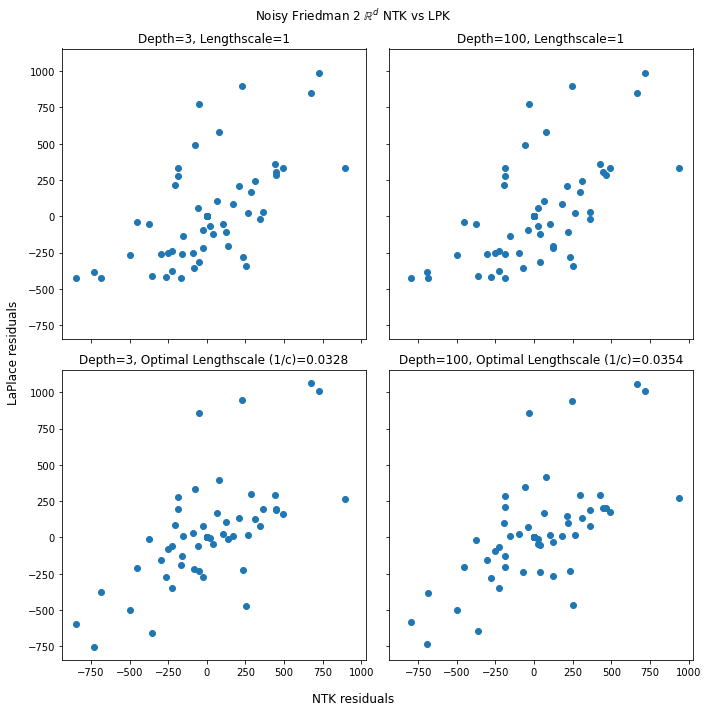

In [96]:
fig1, ax1 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
ax1 = ax1.ravel()
ax1[0].scatter(y - mean_ntk_1, y - mean_lpk)
ax1[0].set_title('Depth=3, Lengthscale=1')
ax1[1].scatter(y - mean_ntk_2, y - mean_lpk)
ax1[1].set_title('Depth=100, Lengthscale=1')
ax1[2].scatter(y - mean_ntk_1, y - mean_opt_1)
ax1[2].set_title(f'Depth=3, Optimal Lengthscale (1/c)={round(ell_3.x, 4)}')
ax1[3].scatter(y - mean_ntk_2, y - mean_opt_2)
ax1[3].set_title(f'Depth=100, Optimal Lengthscale (1/c)={round(ell_100.x, 4)}')
fig1.suptitle(r'Noisy Friedman 2 $\mathbb{R}^d$ NTK vs LPK')
fig1.supxlabel('NTK residuals')
fig1.supylabel('LaPlace residuals')
fig1.tight_layout()

### $\mathbb{S}^{d-1}$

In [97]:
ntk_1 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=3, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e2)
    ) 
)

ntk_2 = (
    ConstantKernel(
        constant_value=1, 
        constant_value_bounds=(1e-9, 1e2)
    ) * 
    NTK(depth=100, c=2, 
        bias=1e-1, 
        bias_bounds=(1e-9, 1e2)
    ) 
)

lpk = (
    ConstantKernel(
        constant_value=0.224**2, 
        constant_value_bounds='fixed'#(1e-9, 1e5) 
    ) * 
    Matern(
        nu=1/2,
        length_scale=1,
        length_scale_bounds='fixed'#(1e-1, 1e3), 
    ) 
)

gp_ntk_1 = GPR(kernel=ntk_1, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_1.fit(X_train_norm, y_train)
print('NTK     : ', gp_ntk_1.kernel_)
mean_ntk_1 = gp_ntk_1.predict(X_norm)

gp_ntk_2 = GPR(kernel=ntk_2, alpha=1e-9, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_2.fit(X_train_norm, y_train)
print('NTK     : ', gp_ntk_2.kernel_)
mean_ntk_2 = gp_ntk_2.predict(X_norm)

gp_lpk = GPR(kernel=lpk, alpha=1e-9, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)
gp_lpk.fit(X_train_norm, y_train)
print('Laplace : ', gp_lpk.kernel_)
mean_lpk = gp_lpk.predict(X_norm)

NTK     :  0.356**2 * NTK(depth=3, c=2.000, bias=25.704)
NTK     :  0.0488**2 * NTK(depth=100, c=2.000, bias=6.490)
Laplace :  0.224**2 * Matern(length_scale=1, nu=0.5)


In [98]:
# arg_list = (gp_lpk, X_norm, X_train_norm, y_train, y-mean_ntk_1, False)
# N = 10000
# ell_search = np.linspace(0.01, 100, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_1 = p.map(f, args)
#     i = np.argmax(result_1)
#     print(f"NTK depth 3, LPK lengthscale {ell_search[i]} at {i} with {max(result_1)}")

In [99]:
# arg_list = (gp_lpk, X_norm, X_train_norm, y_train, y-mean_ntk_2, False)
# N = 10000
# ell_search = np.linspace(0.01, 100, N)

# args = [(ell, *arg_list) for ell in ell_search]

# with Pool(4) as p:
#     result_1 = p.map(f, args)
#     i = np.argmax(result_1)
#     print(f"NTK depth 3, LPK lengthscale {ell_search[i]} at {i} with {max(result_1)}")

In [100]:
def g(ell, residual):
    gp_lpk.set_params(**{'kernel__k2__length_scale': ell})
    gp_lpk.fit(X_train_norm, y_train)
    mean = gp_lpk.predict(X_norm)
    return -np.corrcoef((residual)[:,0], (y-mean)[:,0])[0, 1]

In [101]:
ell_3 = optimize.minimize_scalar(g, args=(y-mean_ntk_1), method='bounded', bounds=[0.001, 30], options={'disp':3})
ell_3

 
 Func-count     x          f(x)          Procedure
    1        11.4596    -0.999998        initial
    2        18.5414    -0.999998        golden
    3         7.0828    -0.999999        golden
    4         4.3778    -0.999999        golden
    5        2.70601    -0.999999        golden
    6        1.67279    -0.999999        golden
    7        1.03422    -0.999999        golden
    8        1.96493    -0.999999        parabolic
    9        1.42888    -0.999999        golden
   10        1.65868    -0.999999        parabolic
   11        1.63116    -0.999999        parabolic
   12        1.55389    -0.999999        golden
   13        1.62163    -0.999999        parabolic
   14        1.62292    -0.999999        parabolic
   15        1.62306    -0.999999        parabolic
   16        1.62305    -0.999999        parabolic
   17        1.62615    -0.999999        golden
   18        1.62323    -0.999999        parabolic
   19        1.62312    -0.999999        golden
   20     

     fun: -0.9999991566105527
 message: 'Solution found.'
    nfev: 22
     nit: 22
  status: 0
 success: True
       x: 1.623061439609715

In [102]:
ell_100 = optimize.minimize_scalar(g, args=(y-mean_ntk_2), method='bounded', bounds=[0.001, 30], options={'disp':3})
ell_100

 
 Func-count     x          f(x)          Procedure
    1        11.4596    -0.999467        initial
    2        18.5414    -0.999467        golden
    3         7.0828    -0.999468        golden
    4         4.3778    -0.999469        golden
    5        2.70601    -0.999471        golden
    6        1.67279    -0.999475        golden
    7        1.03422    -0.999481        golden
    8       0.639566    -0.999493        golden
    9       0.395655    -0.999518        golden
   10        0.24491     -0.99957        golden
   11       0.151745    -0.999673        golden
   12      0.0941655    -0.999808        golden
   13      0.0585794     -0.99974        golden
   14       0.097292      -0.9998        parabolic
   15      0.0850334    -0.999825        parabolic
   16      0.0749289    -0.999829        golden
   17      0.0775975     -0.99983        parabolic
   18      0.0784405     -0.99983        parabolic
   19      0.0781031     -0.99983        parabolic
   20      0.078110

     fun: -0.9998302113981682
 message: 'Solution found.'
    nfev: 22
     nit: 22
  status: 0
 success: True
       x: 0.0781074901498984

In [103]:
# D=3
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_3.x})
gp_lpk.fit(X_train_norm, y_train)
mean_opt_1 = gp_lpk.predict(X_norm)

# D=100
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_100.x})
gp_lpk.fit(X_train_norm, y_train)
mean_opt_2 = gp_lpk.predict(X_norm)

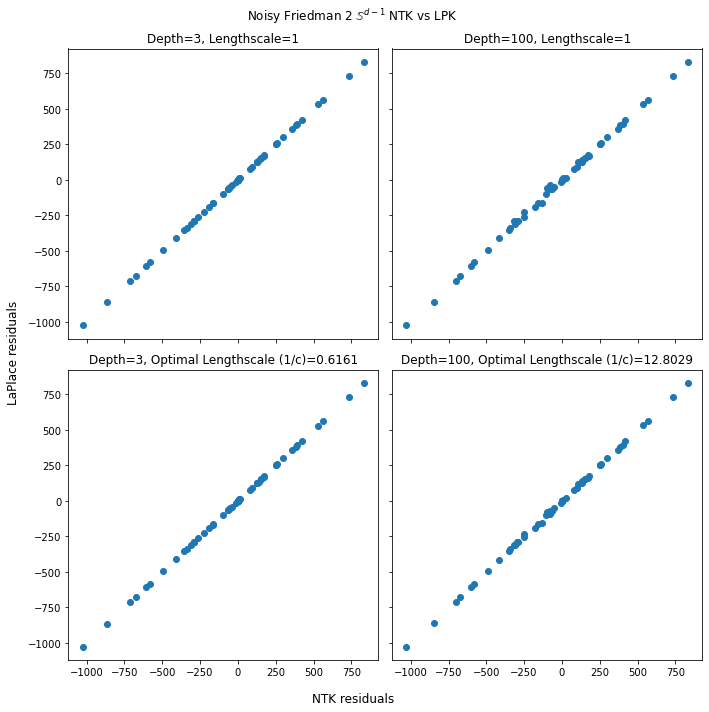

In [104]:
fig2, ax2 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
ax2 = ax2.ravel()
ax2[0].scatter(y - mean_ntk_1, y - mean_lpk)
ax2[0].set_title('Depth=3, Lengthscale=1')
ax2[1].scatter(y - mean_ntk_2, y - mean_lpk)
ax2[1].set_title('Depth=100, Lengthscale=1')
ax2[2].scatter(y - mean_ntk_1, y - mean_opt_1)
ax2[2].set_title(f'Depth=3, Optimal Lengthscale (1/c)={round(ell_3.x, 4)}')
ax2[3].scatter(y - mean_ntk_2, y - mean_opt_2)
ax2[3].set_title(f'Depth=100, Optimal Lengthscale (1/c)={round(ell_100.x, 4)}')
fig2.suptitle(r'Noisy Friedman 2 $\mathbb{S}^{d-1}$ NTK vs LPK')
fig2.supxlabel('NTK residuals')
fig2.supylabel('LaPlace residuals')
fig2.tight_layout()

### RBF

In [105]:
rbf = (
        ConstantKernel(
            constant_value=0.224**2, 
            constant_value_bounds='fixed'#(1e-9, 1e5) 
        ) * 
        Matern(
            nu=np.inf,
            length_scale=1,
            length_scale_bounds='fixed',#(1e-1, 1e3), 
        ) 
    )

gp_rbf = GPR(kernel=rbf, alpha=1e-10, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)
gp_rbf.fit(X_train_norm, y_train)
mean_rbf = gp_rbf.predict(X_norm)

In [106]:
def h(ell, residual):
    gp_rbf.set_params(**{'kernel__k2__length_scale': ell})
    gp_rbf.fit(X_train_norm, y_train)
    mean = gp_rbf.predict(X_norm)
    return -np.corrcoef((residual)[:,0], (y-mean)[:,0])[0, 1]

In [107]:
ell_3 = optimize.minimize_scalar(h, args=(y-mean_ntk_1), method='bounded', bounds=[0.001, 10000], options={'disp':3})
ell_3

 
 Func-count     x          f(x)          Procedure
    1        3819.66    -0.550702        initial
    2        6180.34    -0.542569        golden
    3        2360.68    -0.560139        golden
    4        1458.98    -0.570581        golden
    5          901.7    -0.578819        golden
    6        557.282    -0.583462        golden
    7         344.42    -0.585503        golden
    8        212.863    -0.585987        golden
    9        171.576     -0.58577        parabolic
   10        243.056    -0.585985        parabolic
   11        227.516    -0.585998        parabolic
   12        227.359    -0.585999        parabolic
   13        224.241    -0.585998        parabolic
   14        226.168    -0.585998        golden
   15        226.829    -0.585999        parabolic
   16        227.157    -0.585999        golden
   17        227.282    -0.585999        golden
   18        227.343    -0.585998        parabolic
   19        227.359    -0.585999        parabolic
   20     

     fun: -0.5859985615082116
 message: 'Solution found.'
    nfev: 27
     nit: 27
  status: 0
 success: True
       x: 227.3587970740914

In [108]:
ell_100 = optimize.minimize_scalar(h, args=(y-mean_ntk_2), method='bounded', bounds=[0.001, 100000], options={'disp':3})
ell_100

 
 Func-count     x          f(x)          Procedure
    1        38196.6    -0.487158        initial
    2        61803.4    -0.476875        golden
    3        23606.8    -0.504985        golden
    4        14589.8    -0.525742        golden
    5           9017    -0.541062        golden
    6        5572.81    -0.550354        golden
    7        3444.19    -0.558206        golden
    8        2128.62    -0.567588        golden
    9        1315.56    -0.577342        golden
   10        813.063    -0.584455        golden
   11        502.501    -0.588226        golden
   12        310.563    -0.589751        golden
   13        191.939    -0.589826        golden
   14        237.841    -0.589959        parabolic
   15        244.732    -0.589956        parabolic
   16        238.098    -0.589958        parabolic
   17        236.946    -0.589959        parabolic
   18        237.499    -0.589958        golden
   19         237.71    -0.589959        golden
   20        237.939  

     fun: -0.5899585562793632
 message: 'Solution found.'
    nfev: 31
     nit: 31
  status: 0
 success: True
       x: 237.87833002797998

In [109]:
# D=3
gp_rbf.set_params(**{'kernel__k2__length_scale': ell_3.x})
gp_rbf.fit(X_train_norm, y_train)
mean_opt_1 = gp_rbf.predict(X_norm)

# D=100
gp_rbf.set_params(**{'kernel__k2__length_scale': ell_100.x})
gp_rbf.fit(X_train_norm, y_train)
mean_opt_2 = gp_rbf.predict(X_norm)

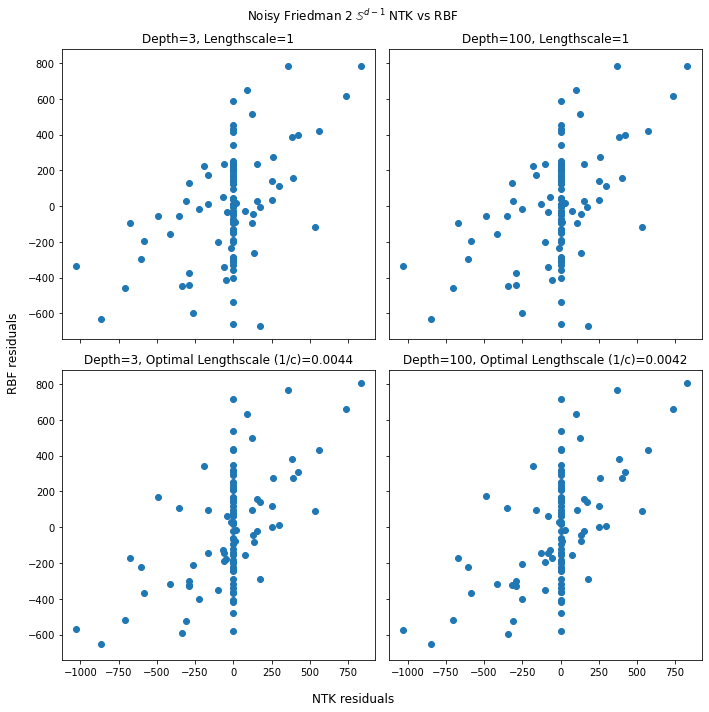

In [110]:
fig2, ax2 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
ax2 = ax2.ravel()
ax2[0].scatter(y - mean_ntk_1, y - mean_rbf)
ax2[0].set_title('Depth=3, Lengthscale=1')
ax2[1].scatter(y - mean_ntk_2, y - mean_rbf)
ax2[1].set_title('Depth=100, Lengthscale=1')
ax2[2].scatter(y - mean_ntk_1, y - mean_opt_1)
ax2[2].set_title(f'Depth=3, Optimal Lengthscale (1/c)={round(ell_3.x, 4)}')
ax2[3].scatter(y - mean_ntk_2, y - mean_opt_2)
ax2[3].set_title(f'Depth=100, Optimal Lengthscale (1/c)={round(ell_100.x, 4)}')
fig2.suptitle(r'Noisy Friedman 2 $\mathbb{S}^{d-1}$ NTK vs RBF')
fig2.supxlabel('NTK residuals')
fig2.supylabel('RBF residuals')
fig2.tight_layout()

In [111]:
# lengthscale = np.linspace(0.1, 5, 50)

# fig, ax = plt.subplots(nrows=10, ncols=5, sharex=True, sharey=True, figsize=(15, 30))
# ax=ax.ravel()

# for x, ax in zip(lengthscale, ax):
#     rbf = (
#         ConstantKernel(
#             constant_value=0.05, 
#             constant_value_bounds=(1e-9, 1e5) 
#         ) * 
#         Matern(
#             nu=np.inf,
#             length_scale=x,
#             length_scale_bounds='fixed',#(1e-1, 1e3), 
#         ) 
#     )

#     gp = GPR(kernel=rbf, alpha=1e-10, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
#     gp.fit(X_train_norm, y_train)
#     mean_rbf = gp.predict(X_norm)

#     ax.set_title(f'RBF Lengthscale={x.round(2)}')
#     ax.scatter(y-mean_ntk_1, y-mean_rbf)

# fig.suptitle(r"NTK vs RBF Kernel in $\mathbb{S}^{d-1}$")
# fig.supxlabel('NTK residuals')
# fig.supylabel('RBF residuals')
# fig.tight_layout()

In [112]:
# rbf = (
#     ConstantKernel(
#         constant_value=0.05, 
#         constant_value_bounds=(1e-9, 1e5) 
#     ) * 
#     Matern(
#         nu=np.inf,
#         length_scale=0.35,
#         length_scale_bounds=(1e-1, 1e3), 
#     ) 
# )

# gp = GPR(kernel=rbf, alpha=1e-10, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
# gp.fit(X_train_norm, y_train)
# mean_rbf = gp.predict(X_norm)
# print(rbf)
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.set_title(f'RBF Lengthscale={0.35}')
# ax.scatter(y-mean_ntk_1, y-mean_rbf)

In [113]:
np.corrcoef((y-mean_ntk_1)[:,0], (y-mean_rbf)[:,0])

array([[1.        , 0.51143652],
       [0.51143652, 1.        ]])

In [114]:
np.corrcoef((y-mean_ntk_1)[:,0], (y-mean_lpk)[:,0])

array([[1.        , 0.99999889],
       [0.99999889, 1.        ]])